In [1]:
!pip install tensorflow  tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteGO97ZY/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteGO97ZY/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## 2. Viz data and build dataset

In [5]:
import numpy as np

# set up connection aka iterator
dataiterator = ds.as_numpy_iterator()
# getting data out of pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

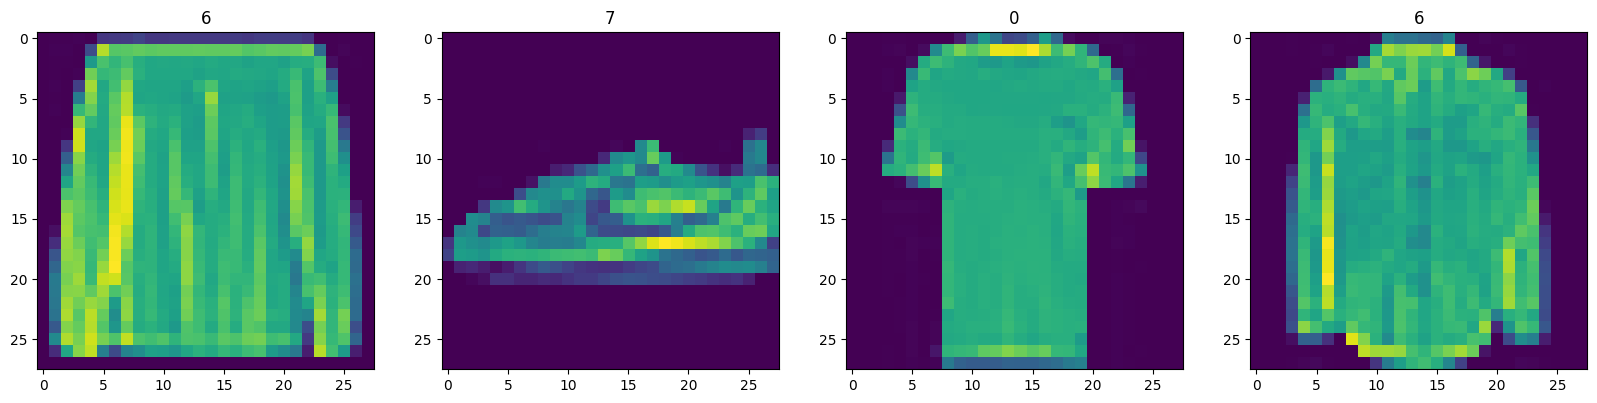

In [45]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  #grab an image and label
  sample = dataiterator.next()
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # appending the image label as the plot title
  ax[idx].title.set_text(sample['label'])

In [46]:
# scale and return images only
def scale_images(data):
  image = data['image']
  return image / 255

In [47]:
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# reduce the liklihood of bottlencking
ds = ds.prefetch(64)

In [48]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build the Neural Network

### 3.1 Import modelling components

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build generator

In [50]:
from keras.src.metrics.confusion_metrics import activations
def build_generator():
  model = Sequential()

  # takes in random values and reshapes it to 7x7x128
  #beginnings of a renerated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))


  return model

In [51]:
generator = build_generator()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_11 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [71]:
img = generator.predict(np.random.randn(4, 128,  1))
img

1/1 [==============================] - 0s 27ms/step


array([[[[0.51209104],
         [0.5096324 ],
         [0.5144511 ],
         ...,
         [0.508122  ],
         [0.50157094],
         [0.5054344 ]],

        [[0.50750345],
         [0.51131546],
         [0.5185101 ],
         ...,
         [0.50573504],
         [0.500167  ],
         [0.5024875 ]],

        [[0.5049867 ],
         [0.5104616 ],
         [0.51185846],
         ...,
         [0.5098884 ],
         [0.50136787],
         [0.50318027]],

        ...,

        [[0.5025151 ],
         [0.50200546],
         [0.50724447],
         ...,
         [0.49582422],
         [0.49018463],
         [0.49552384]],

        [[0.5077482 ],
         [0.5048185 ],
         [0.5077196 ],
         ...,
         [0.4982443 ],
         [0.49419662],
         [0.4967078 ]],

        [[0.50551516],
         [0.5058562 ],
         [0.5056386 ],
         ...,
         [0.49959752],
         [0.4965361 ],
         [0.50001824]]],


       [[[0.51089823],
         [0.5066352 ],
         [0.50

In [72]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 35ms/step


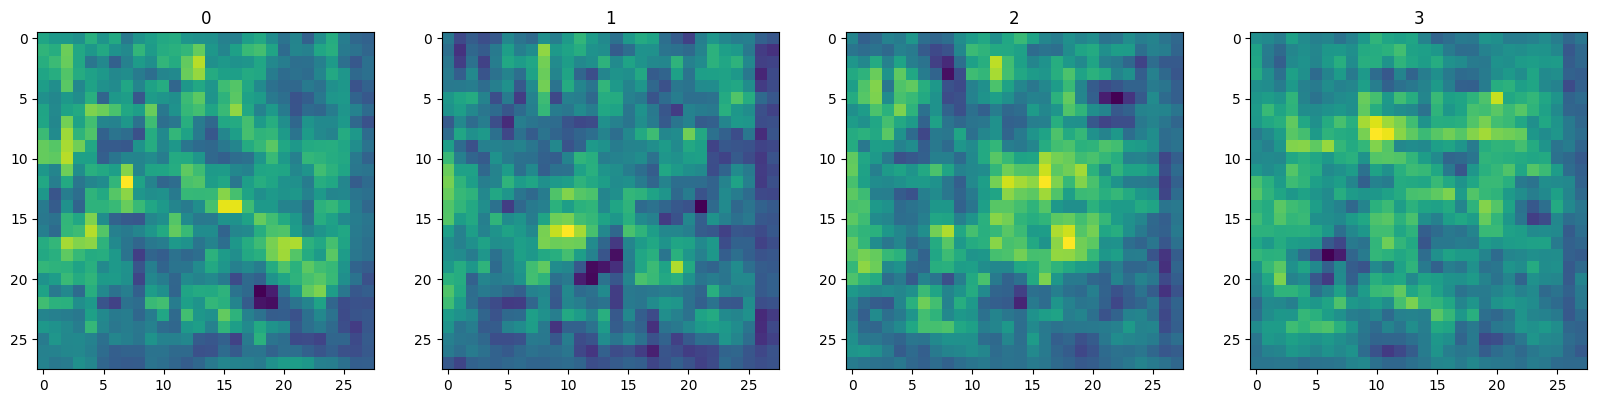

In [73]:
# generate new fashion
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(img):
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # appending the image label as the plot title
  ax[idx].title.set_text(idx)

### 3.3 Build discriminator

In [74]:
def build_discriminator():
  model = Sequential()

  # first conv block
  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # second conv block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # third conv block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # fourth conv block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [75]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_13 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 128)     

In [78]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 30ms/step


In [79]:
img.shape

(4, 28, 28, 1)

In [80]:
discriminator.predict(img)

1/1 [==============================] - 0s 294ms/step


array([[0.49967435],
       [0.49972716],
       [0.49928707],
       [0.4995364 ]], dtype=float32)

In [81]:
img = img[0]
img.shape

(28, 28, 1)

In [82]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 213ms/step


array([[0.4996743]], dtype=float32)

## 4.